# Inference: Reusing openEO workflows saved as User-Defined Processes (UDP)

This notebook is a follow-up to the “Forest Fire Mapping Using Random Forest in openEO” notebook. While the original focused on building and running a machine learning workflow for forest fire detection, this notebook demonstrates how to save that workflow into a reusable solution using openEO’s User-Defined Process (UDP) functionality for inference or prediction.

In openEO, users can chain together processing steps in a process graph. Often, users have specific (sub)graphs that reoccur in the same process graph or even in different process graphs or algorithms.  These process graphs can be reused at various scales and with varying inputs, making them highly flexible and efficient for repeated analysis.

This notebook walks through how to create a UDP from the earlier use case, allowing you to integrate it into future workflows or share it with other users.

*Please note: While users can share the trained model and full inference workflow directly, this notebook emphasises a more sustainable, scalable, and maintainable approach for inference.*


In [ ]:
# !pip install geopandas scikit-learn folium numpy pandas rasterio 

In [ ]:
import json

import openeo
from openeo.api.process import Parameter
from openeo.rest.udp import build_process_dict

from helper_functions import read_json, view_aoi, plot_pred
from eo_extractor import s1_features , s2_features


connection = openeo.connect("openeo.dataspace.copernicus.eu").authenticate_oidc()

Authenticated using refresh token.


In openEO, input parameters for a User-Defined Process (UDP) can be defined using the Parameter class from the openeo.api.process module. Each parameter includes a name, a description, and optionally a schema to define expected input types.

While this workflow can support multiple configurable inputs, this notebook focuses on two key parameters: spatial extent and temporal extent. 


In [3]:
# define input parameter
spatial_extent = Parameter.spatial_extent(
    name = "spatial_extent", 
    description = "Limits the data to process to the specified bounding box or polygons."
    )

temporal_extent = Parameter.temporal_interval(
    name = "temporal_extent", 
    description = "Temporal extent specified as two-element array with start and end date/date-time."
    )

padding_window_size = Parameter.integer(
    name = "padding_window_size",
    description = "Padding window size for GLCM computation. Eg. when padding_window_size is set to 33, it refers to a 33x33 pixel window. 32 up/down or left/right pixels are added.",
    default = 33
)

Use the parameters directly as arguments to workflow to build the datacube.


In [4]:
# Load s1 and s2 features
s1_feature_cube = s1_features(connection, temporal_extent, spatial_extent, "median")
s2_feature_cube = s2_features(connection, temporal_extent, spatial_extent, "median", padding_window_size)
# Merge the two feature cubes
inference_cube = s2_feature_cube.merge_cubes(s1_feature_cube)

In [ ]:
# link to the trained model
model = "https://s3.waw3-1.cloudferro.com/swift/v1/apex-examples/RF-ForestFire/RandomForest-ForestFire-model.json"

In this example, we load the model saved from the training notebook hosted on a public S3 bucket.

In [6]:
# predict of training data
inference = inference_cube.predict_random_forest(
    model=model,
    dimension="bands"
)

We can now either construct and export this parameterised data cube as a User-Defined Process (UDP) in JSON format or directly save it to the openEO back-end for reuse.

The example below demostrates the way of saving the UDP as a JSON file. This file can then be hosted on a public repository and shared with other users.

In [8]:
process_graph = build_process_dict(
    process_graph = inference,
    process_id = "fire_using_RF",
    parameters=[temporal_extent, spatial_extent],
    summary = "Forest Fire Mapping Using Random Forest in openEO",
    description = "Forest fire mapping is a critical tool for environmental monitoring and disaster management, enabling the timely detection and assessment of burned areas. This service is build upon techniques described in the research paper by Zhou, Bao et al., which introduces a machine learning–based approach using Sentinel-2 imagery. Their method combines spectral, topographic, and textural features to improve classification accuracy, particularly emphasising GLCM texture features extracted from Sentinel-2's short-wave infrared band.",    
)
with open("fire_using_RF.json", "w") as f:
        json.dump(process_graph, f, indent=2)

## Use the saved User-Defined-Process

In [9]:
# define input parameters
date = ["2023-07-15", "2023-09-15"]
aoi = read_json("Dataset/inference_aoi.geojson")
view_aoi(aoi)


The additional required parameter is `public_url`. If the process is saved as a UDP on the back-end, this URL will be automatically generated and made publicly accessible if flagged as `public`. Alternatively, if the process graph is exported as a JSON file, it can be hosted in any public space and referenced directly. The latter approach—managing and sharing the process via a hosted JSON file—is generally recommended.


In [12]:
public_url = "https://raw.githubusercontent.com/Open-EO/openeo-community-examples/refs/heads/RF_cdse/python/RandomForest-ForestFire/fire_using_RF.json"
forest_fire = connection.datacube_from_process(
        "fire_using_RF", 
        namespace = public_url,
        temporal_extent = date,
        spatial_extent = aoi,
        padding_window_size = 33
        )

In [13]:
forest_fire.execute_batch(outputfile="forest_fire_UDP.tif", title="UDP: Forest Fire")

0:00:00 Job 'j-2509051434094a818eb4cabda664294d': send 'start'
0:00:13 Job 'j-2509051434094a818eb4cabda664294d': created (progress 0%)
0:00:18 Job 'j-2509051434094a818eb4cabda664294d': created (progress 0%)
0:00:25 Job 'j-2509051434094a818eb4cabda664294d': created (progress 0%)
0:00:33 Job 'j-2509051434094a818eb4cabda664294d': created (progress 0%)
0:00:43 Job 'j-2509051434094a818eb4cabda664294d': created (progress 0%)
0:00:55 Job 'j-2509051434094a818eb4cabda664294d': created (progress 0%)
0:01:11 Job 'j-2509051434094a818eb4cabda664294d': queued (progress 0%)
0:01:30 Job 'j-2509051434094a818eb4cabda664294d': queued (progress 0%)
0:01:54 Job 'j-2509051434094a818eb4cabda664294d': queued (progress 0%)
0:02:24 Job 'j-2509051434094a818eb4cabda664294d': queued (progress 0%)
0:03:01 Job 'j-2509051434094a818eb4cabda664294d': queued (progress 0%)
0:03:48 Job 'j-2509051434094a818eb4cabda664294d': queued (progress 0%)
0:04:47 Job 'j-2509051434094a818eb4cabda664294d': queued (progress 0%)
0:05:47 

<BatchJob job_id='j-2509051434094a818eb4cabda664294d'>

# Plot the output


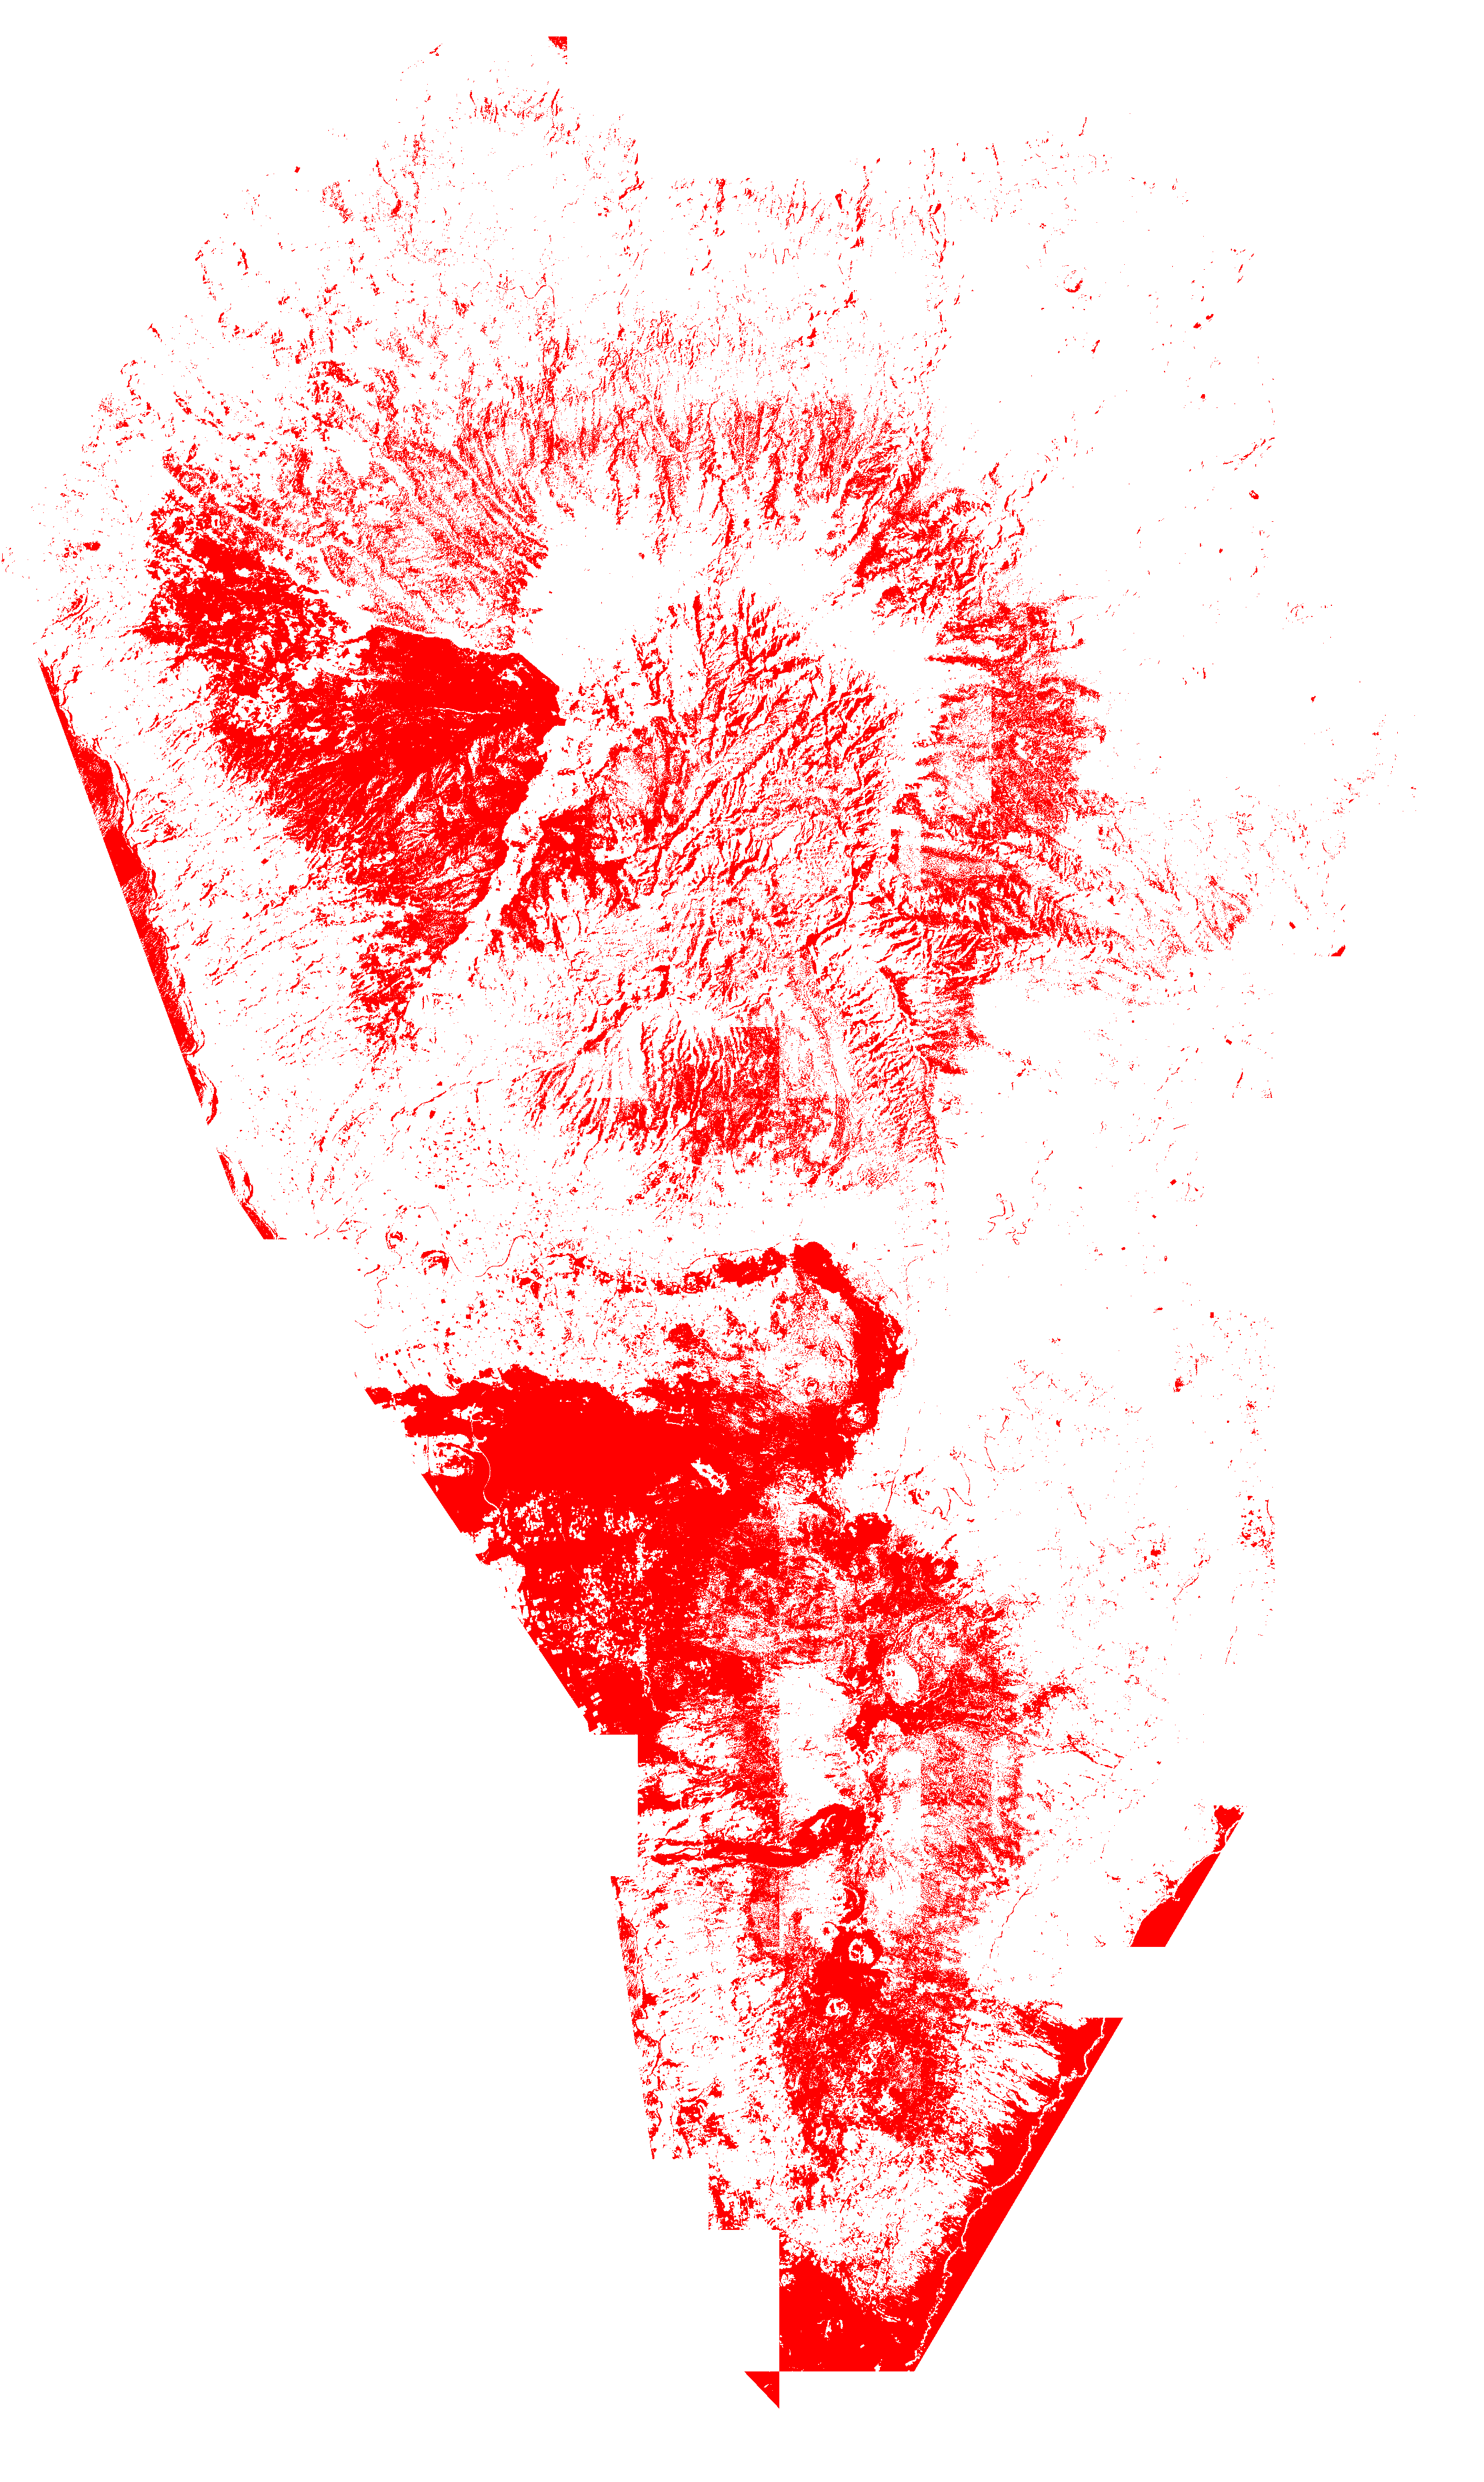

In [16]:
# Paths
predicted =  'forest_fire_UDP.tif'
aoi_path = "Dataset/inference_aoi.geojson"

plot_pred(predicted, aoi_path)

For validation of output: https://rapidmapping.emergency.copernicus.eu/EMSR671/

Therefore, this notebook demonstrated how to create, register, and execute a reusable User-Defined Process (UDP) for forest fire mapping using openEO.

It supports seamless scaling, sharing and reuse by saving the entire workflow—from data extraction to model inference—as an openEO User‑Defined Process (UDP). That means external users can simply plug in their own spatial or temporal extents and run your forest‑fire predictor with minimal effort—no need to stitch together several different code snippets or data transformation steps. This method ensures reproducibility and significantly lowers the reuse barrier.